# Fourth Down Project

Author: Seth Billiau, Sarah Lucioni

In [179]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [180]:
# Load Data
DATADIR = 'data/'
nfl_pbp = pd.read_csv(DATADIR + 'NFL_PbP_2009_2018_4thDownAnalysis.csv')



In [2]:
# TODO: if they score add 6 points (+6), model extra point/2 point-conversion (TODO), 
# subtract giving ball to other team after kickoff (- 0.8)

# point after: (prob of extra point) * (expected value of extra point) + 
#              (prob of two point conversion) * (expected value of two point conversion)
# point after: (prob of extra point) * (prob of successful extra point) * 1 + 
#              (prob of two point conversion) * (prob of successful 2 pt) * 2


# total plays after TD:
extra_point_plays = sum(nfl_pbp.extra_point_attempt == 1)
two_point_plays = sum(nfl_pbp.two_point_attempt == 1)
plays_after_TD = extra_point_plays + two_point_plays
# TODO: this is less than num of touchdowns = sum(nfl_pbp.touchdown == 1)

# nfl_pbp.extra_point_attempt
# nfl_pbp.extra_point_result.unique()
# Prob of extra point
p_extra_point = extra_point_plays / plays_after_TD
# Prob of succesful extra point
p_extra_point_success = np.mean(nfl_pbp[nfl_pbp.extra_point_attempt == 1].extra_point_result == 'good')

# Prob of 2 pt conversion
p_two_point = two_point_plays / plays_after_TD
# Prob of succesful 2 pt conversion
p_two_point_success = np.mean(nfl_pbp[nfl_pbp.two_point_attempt == 1].two_point_conv_result == 'success')
# nfl_pbp.two_point_attempt.describe()
# nfl_pbp.two_point_conv_result.unique()


# EV points after TD
expected_points_after = p_extra_point * p_extra_point_success + 2 * p_two_point * p_two_point_success
expected_points_after

0.9709606618267771

# Fourth Down Model

## Global Variables

In [20]:
# 4th and ... (+ 1)
max_fourth_ytg = 21

# Yardline (+ 1)
max_yardline = 100

## Expected Value of Going for it

In [21]:
# TODO - remove outlier points? (going for it at the end of the 4th quarter)

In [218]:

# Find all pass/run, yards to go in the dataset (all yards)
    # Calculate proportion of those plays 

def prob_of_first_down(by_qtr_flag=False, qtr=None):
    """
    Calculates dictionary of probabilities of getting a first down given yds to go
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yards to go, values are probs. of first down given yards to go
    """
    
    passRunPlays = nfl_pbp[(nfl_pbp.play_type == "pass") | 
                           (nfl_pbp.play_type == 'run')]
    
    if by_qtr_flag:
        passRunPlays = passRunPlays[passRunPlays.qtr == qtr]
    
    # Get average probability of getting a first down 
    probFirstDown = {}
    for x in range(1, max_fourth_ytg):
        probFirstDown[x] = np.mean(passRunPlays.yards_gained[passRunPlays.ydstogo == x ] >= x)
        
    # smooth using cubic polynomial
    smoothedValues = poly_smooth_with_nan(np.arange(1,21,1),np.fromiter(probFirstDown.values(), dtype="float").copy(),deg=3)[0]
    probFirstDown = dict(zip(range(1,21),smoothedValues))
    
    return probFirstDown


In [219]:
def expected_points_on_first(by_qtr_flag=False, qtr=None):
    """
    Calculates expected points for a first down given yardline 
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yards to go, values are expected value of first down given yardline
    """
    
    firstDownPlays = nfl_pbp[nfl_pbp.down == 1]
    
    if by_qtr_flag:
        firstDownPlays = firstDownPlays[firstDownPlays.qtr == qtr]
        
    expectedPointsOnFirst = {}
    for x in range(1, max_yardline): 
        expectedPointsOnFirst[x] = np.mean(firstDownPlays[firstDownPlays.yardline_100 == x].next_score_relative_to_posteam)   
        
#     if smooth_flag == True:
#         smoothedValues = non_parametric_smooth_with_nan(np.fromiter(expectedPointsOnFirst.values(), dtype="float").copy(),window=window)
#         expectedPointsOnFirst = dict(zip(range(1,100),smoothedValues))
    
    return expectedPointsOnFirst


In [220]:
def cost_of_turnover(expectedPointsOnFirst):
    """
    Calculates cost of a turnover given yardline 

    Returns:
    costOfTurnover (dict): Keys are yards to go, values are expected cost of turnover given yardline
    """
        
    costOfTurnover = {}
    for x in range(1, max_yardline): 
         costOfTurnover[x] = -1 * expectedPointsOnFirst[max_yardline - x]
            
    return costOfTurnover

In [222]:
def expected_value_go_for_it(by_qtr_flag=False, qtr=None):
    """
    Calculates expected points of going for it for given yds to go and yardline
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict of dicts: Outer dict Keys are yardlines, Inner dict keys are yards to go, 
                                          values are expected points of going for it. 
    """
    
    # Initialize all of the necessary components based on quarter before calculating the expected value
    probFirstDown = prob_of_first_down(by_qtr_flag, qtr)
    expectedPointsOnFirst = expected_points_on_first(by_qtr_flag, qtr)
    costOfTurnover = cost_of_turnover(expectedPointsOnFirst)
    
    expectedValueGoForIt = {}
    
    for yardline in range(1, max_yardline):
        outcome_per_yardline = {}
        for yardstogo in range(1, max_fourth_ytg): 
            if (yardline - yardstogo) == 0:
                # TODO: if they score add 6 points (+6), model extra point/2 point-conversion (TODO), subtract giving ball to other team after kickoff (- 0.8)
                fourth_and_goal_expected_points = 6 + expected_points_after - 0.8
                outcome_per_yardline[yardstogo] = probFirstDown[yardstogo] * fourth_and_goal_expected_points + (1 - probFirstDown[yardstogo]) * costOfTurnover[yardline]
            elif (yardline - yardstogo) < 0:
                pass
            else: 
                outcome_per_yardline[yardstogo] = probFirstDown[yardstogo] * expectedPointsOnFirst[yardline - yardstogo] + (1- probFirstDown[yardstogo]) * costOfTurnover[yardline]
        
        expectedValueGoForIt[yardline] = outcome_per_yardline
    
    return expectedValueGoForIt


## Expected Value of Punt

In [223]:
def expected_value_punt(by_qtr_flag=False, qtr=None):
    """
    Calculates expected points of punting given yardline
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yardlines, values are expected points of punting 
    """
        
    expectedPointsOnFirst = expected_points_on_first(by_qtr_flag, qtr)
    
    puntPlays = nfl_pbp[nfl_pbp.play_type == "punt"]
    
    if by_qtr_flag:
        puntPlays = puntPlays[puntPlays.qtr == qtr]
        
    expectedValuePunt = {}
    touchback_max = 80
    touchback_EV = -1 * expectedPointsOnFirst[touchback_max]
    for x in range(1, max_yardline): 
        net_punt_distance = np.round(np.mean(puntPlays[puntPlays.yardline_100 == x].kick_distance))
        if math.isnan(net_punt_distance):
            # If there's inadequate data, it's likely because you'd never punt. But if you would punt, it would 
            # be a touchback so for consistency, we'll just add the touchback expected value
            expectedValuePunt[x] = touchback_EV
        else: 
            expectedValuePunt[x] = -1 * expectedPointsOnFirst[min(max_yardline -  x + net_punt_distance, touchback_max)]

    return expectedValuePunt



## Expected Value of FG

In [224]:
# Expected Score for FG 

# FG is 3 points, minus the value of giving the ball back to the opponent at the 75 (-0.8)
expectedValueOfFG = 3 - 0.8

In [225]:
def FG_success_prob(by_qtr_flag=False, qtr=None):
    """
    Calculates probability of a made FG given yardline
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yardlines, values are probabilities of making a FG
    """
        
    # find field goal attempts
    field_goal_attempts = nfl_pbp[nfl_pbp['field_goal_attempt']==1]
    
    if by_qtr_flag:
        field_goal_attempts = field_goal_attempts[field_goal_attempts.qtr == qtr]
        
    # initialize arrays
    field_goal_success_rate = np.zeros(99)
    field_goal_number_attempts = np.zeros(99)
    field_position = np.arange(1, max_yardline) # i.e. from 1-99 yards
    for i in field_position: # i.e. from 1-99 yards
        relevant_rows = field_goal_attempts.yardline_100==i
        field_goal_number_attempts[i-1] = np.sum(relevant_rows)
        if field_goal_number_attempts[i-1]>0:
            field_goal_success_rate[i-1] = np.sum( field_goal_attempts[relevant_rows].posteam_score_post > field_goal_attempts[relevant_rows].posteam_score) / np.sum(relevant_rows)
        else:
            field_goal_success_rate[i-1] = np.nan # no data at this distance

    # # non-parmetric filter
    # field_goal_success_rate_smooth_noparam = non_parametric_smooth_with_nan(field_goal_success_rate.copy(),window=21)

    # make piecewise polynomial fit
    field_goal_success_rate_smooth_poly = np.zeros(99)
    cut_distance = 49 # anything greater than this is set to zero
    field_goal_success_rate_smooth_poly[field_position<=cut_distance] = poly_smooth_with_nan(field_position[field_position<=cut_distance],field_goal_success_rate[field_position<=cut_distance],deg=3)[0]
    
    return dict(zip(range(1,99), np.clip(field_goal_success_rate_smooth_poly, a_min = 0, a_max = 1)))

In [226]:
def expected_value_FG(by_qtr_flag=False, qtr=None):
    """
    Calculates expected points of attempting a FG given yardline
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yardlines, values are expected points of attempting a FG
    """
    
    FGSuccessRate = FG_success_prob(by_qtr_flag, qtr)
    expectedPointsOnFirst = expected_points_on_first(by_qtr_flag, qtr)
    
    expectedPointsForFG = {}
    
    for x in range(1, max_yardline):
        if max_yardline - (x + 8) > 0: 
            expectedPointsForFG[x] = FGSuccessRate[x] * expectedValueOfFG - (1- FGSuccessRate[x]) * expectedPointsOnFirst[min(80, max_yardline - (x + 8))]
    
    return expectedPointsForFG 

## Visualization

In [230]:
# 100 for yardline 
# 20 for yards to go

def get_choices(by_qtr_flag=False, qtr=None):
    """
    Calculates optimal choice given yardline and yards to go
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    array, array: Array of optimal choices, array of optimal expected points 
    """
    
    # Initialize all of the necessary expected value data structures
    expectedPointsForFG = expected_value_FG(by_qtr_flag, qtr)
    expectedValuePunt = expected_value_punt(by_qtr_flag, qtr)
    expectedValueGoForIt = expected_value_go_for_it(by_qtr_flag, qtr)
    

    # Create dictionaries and an array to keep track of the max expected value and the choices
    expectedPointsArray = {}
    choiceArray = {}
    choiceArrayNP = np.zeros((max_fourth_ytg, max_yardline))

    choiceList = ["FG", "Punt", "Go For It"]
    for yardline in range(1, max_yardline):
        if yardline > 91: 
            # Don't kick a FG you idiot
            # Set this to some incredibly high value so that it'll never be chosen
            FGexpected = -100 
        else:
            FGexpected = expectedPointsForFG[yardline]

#         if yards < 30:
#             # Don't punt you idiot
#             # Set this to the touchback value b
#             puntExpected = puntExpected[1]
#         else:
        puntExpected = expectedValuePunt[yardline]


        for yardstogo in range(1, min(yardline, max_fourth_ytg - 1) + 1):
            if yardstogo == 1: 
                choiceArray[yardline] = {}
                expectedPointsArray[yardline] = {}
                
            GoForItExpected = expectedValueGoForIt[yardline][yardstogo]
            choiceID = np.array([FGexpected, puntExpected, GoForItExpected]).argmax()

            choiceArray[yardline][yardstogo] = choiceList[choiceID]
            if max_yardline - yardline - yardstogo < 0:
                # If it's an impossible scenario (more yardstogo than left on the field), set the choice to 0
                choiceArrayNP[yardstogo][yardline] = 0
            else:
                # Set the choice to the ID + 1 so that 0 indicates impossible positions
                choiceArrayNP[yardstogo][yardline] = choiceID + 1
                
            expectedPointsArray[yardline][yardstogo] = max([FGexpected, puntExpected, GoForItExpected])

    return choiceArrayNP, expectedPointsArray


In [228]:
def visualize_model(by_qtr_flag=False, qtr=None):
    """
    Visualizes optimal choices given yardline and yards to go
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    None: Side effect creates a plot.
    """
    choiceArrayNP, _ = get_choices(by_qtr_flag, qtr)
    
    # Create an array mask so that we don't plot the 0 values
    choice_mask = np.ma.masked_values(choiceArrayNP, 0)
    
    plt.figure(figsize=(14, 9))
    with sns.axes_style("white"):
        ax = sns.heatmap(choiceArrayNP, mask=choice_mask.mask, vmin=0, vmax=3, xticklabels=5, yticklabels=1, 
                         cmap="viridis", cbar=False, linewidths=.1)
        ax.set(xlim=(1, max_yardline), ylim=(max_fourth_ytg, 1))
    plt.ylabel("4th and ...", fontsize=14)
    plt.xlabel("Yard Line", fontsize=14)
    plt.show()

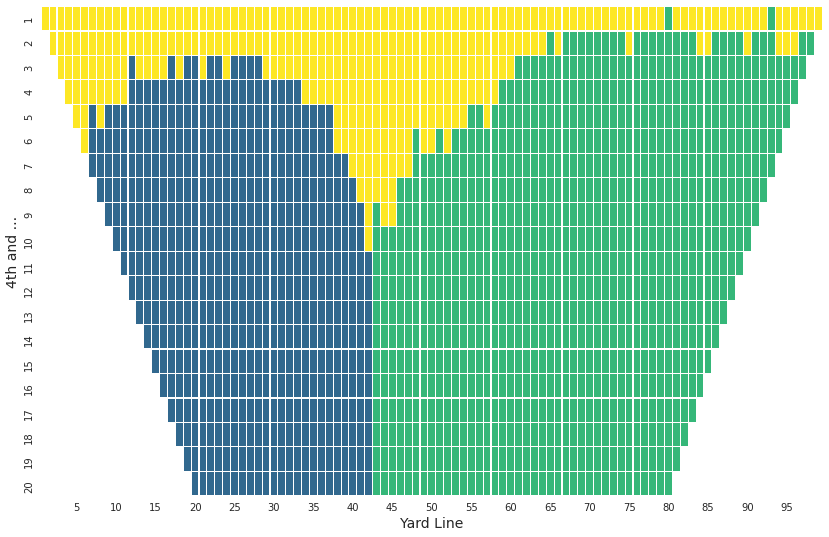

In [229]:
# Fourth Down Model for an average time/play in a game 
# (NOT for a few seconds before the end of game or when you are losing terribly)
visualize_model()

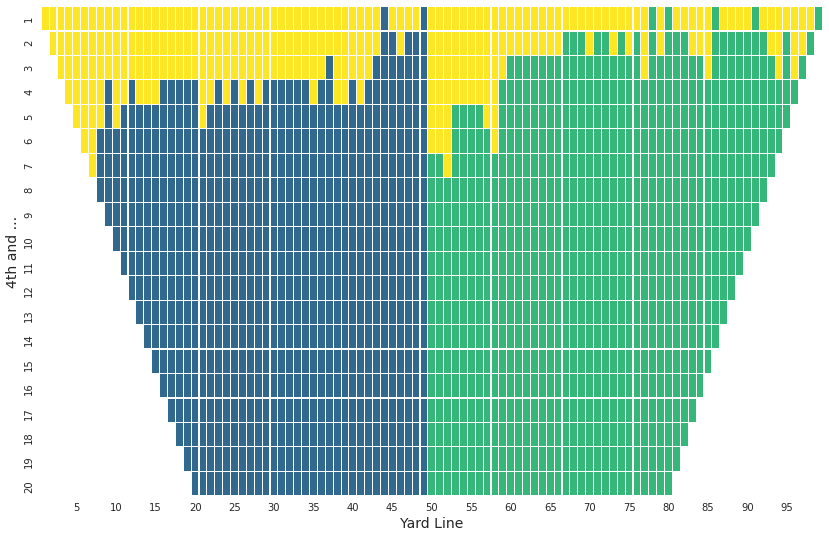

In [165]:
# Fourth Down Model for an average time/play in the first quarter 
visualize_model(True, 1)

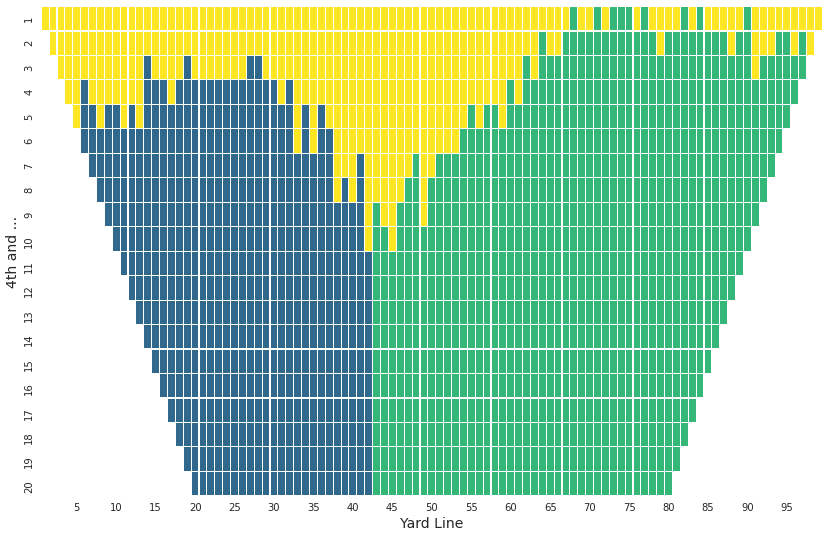

In [166]:
# Fourth Down Model for an average time/play in the second quarter 
visualize_model(True, 2)

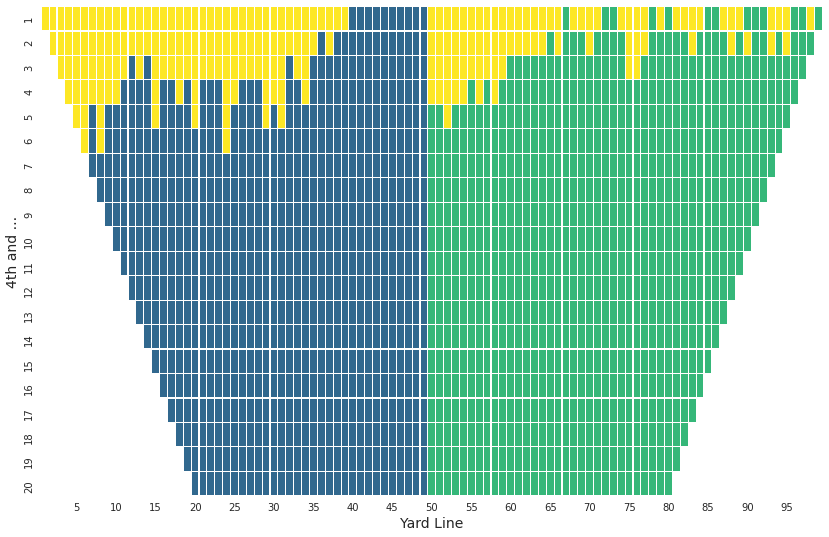

In [231]:
# Fourth Down Model for an average time/play in the third quarter 
visualize_model(True, 3)

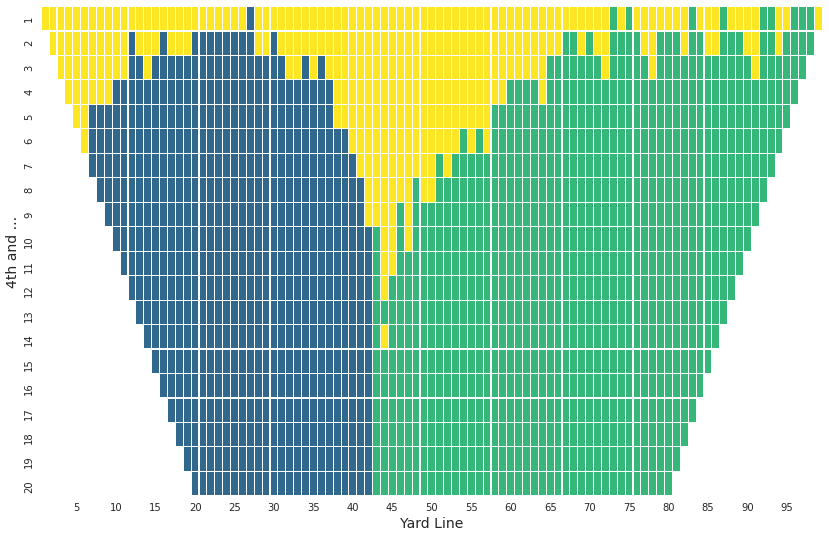

In [168]:
# Fourth Down Model for an average time/play in the fourth quarter 
visualize_model(True, 4)

## Uncleaned Code

In [162]:


# Expected Score for Going for it
# P(getting yards to go | 4th down) E(1D at 1st down yardage ) + (1 - P(getting yards to go | 4th down)) * E[Value of 1D at yardage for other team / turnover @ yardage ]

# Find all pass/run, yards to go in the dataset (all yards)
    # Calculate proportion of those plays 

passRunPlays = nfl_pbp[(nfl_pbp.play_type == "pass") | (nfl_pbp.play_type == 'run')]

probFirstDown = dict()
for x in range(1, 26):
    # print(len(passRunPlays.yards_gained[passRunPlays.ydstogo == x ]))
    probFirstDown[x] = np.mean(passRunPlays.yards_gained[passRunPlays.ydstogo == x ] >= x)
    
probFirstDown


{1: 0.6589875719915126,
 2: 0.5554759559416137,
 3: 0.49961867638335733,
 4: 0.44921150278293137,
 5: 0.4120660945305495,
 6: 0.3562562230335214,
 7: 0.3320202219158296,
 8: 0.2967504598405886,
 9: 0.259558765800424,
 10: 0.209928781956409,
 11: 0.2265361242403781,
 12: 0.19864612511671334,
 13: 0.17261729123635292,
 14: 0.1611214953271028,
 15: 0.13761964962976342,
 16: 0.11542610571736785,
 17: 0.10541149943630214,
 18: 0.08704188481675393,
 19: 0.08326787117046347,
 20: 0.07272249934365975,
 21: 0.06440677966101695,
 22: 0.0498812351543943,
 23: 0.047337278106508875,
 24: 0.050387596899224806,
 25: 0.04093567251461988}

In [163]:

firstDownPlays = nfl_pbp[nfl_pbp.down == 1]

expectedPointsOnFirst = {}
for x in range(1, 100): 
    expectedPointsOnFirst[x] = np.mean(firstDownPlays[firstDownPlays.yardline_100 == x].next_score_relative_to_posteam)
expectedPointsOnFirst


{1: 5.433887043189369,
 2: 5.188144329896907,
 3: 5.195402298850575,
 4: 4.931506849315069,
 5: 4.882211538461538,
 6: 4.6678321678321675,
 7: 4.558679706601467,
 8: 4.644599303135888,
 9: 4.383891213389122,
 10: 4.3526011560693645,
 11: 4.231768231768232,
 12: 4.171487603305785,
 13: 4.305015353121801,
 14: 4.133083411433927,
 15: 4.238263950398583,
 16: 4.017970401691332,
 17: 3.9930830039525693,
 18: 4.039575289575289,
 19: 3.9262295081967213,
 20: 3.8535564853556483,
 21: 3.8746518105849583,
 22: 3.8111824014665445,
 23: 3.702770780856423,
 24: 3.6327361563517915,
 25: 3.4954337899543377,
 26: 3.62874251497006,
 27: 3.5836092715231787,
 28: 3.4832214765100673,
 29: 3.4223412394797244,
 30: 3.436838390966831,
 31: 3.169811320754717,
 32: 3.211203633610901,
 33: 3.062453531598513,
 34: 3.00202565833896,
 35: 3.171823568136932,
 36: 2.984682713347921,
 37: 2.9160530191458025,
 38: 2.9338549075391183,
 39: 2.8511749347258486,
 40: 2.6564885496183206,
 41: 2.549047282992237,
 42: 2.2783

In [164]:
costOfTurnover = {}
for x in range(1, 100): 
     costOfTurnover[x] = -1 *  expectedPointsOnFirst[100 - x]
costOfTurnover

{1: 0.46782178217821785,
 2: 0.11506849315068493,
 3: 0.05113636363636364,
 4: 0.2116788321167883,
 5: 0.14102564102564102,
 6: 0.025440313111545987,
 7: -0.07964601769911504,
 8: 0.06455696202531645,
 9: -0.15430622009569378,
 10: 0.0696594427244582,
 11: 0.003416856492027335,
 12: -0.4941588785046729,
 13: -0.09577754891864057,
 14: -0.37060414788097384,
 15: -0.1518987341772152,
 16: -0.44298605414273995,
 17: -0.5326633165829145,
 18: -0.5606850335070737,
 19: -0.6913827655310621,
 20: -0.5363859362224039,
 21: -0.3916167664670659,
 22: -0.6826979472140763,
 23: -0.7849145550972304,
 24: -0.6194690265486725,
 25: -0.8991007468373724,
 26: -0.8330578512396695,
 27: -1.0405569007263922,
 28: -0.909358446144791,
 29: -1.0361663652802893,
 30: -0.9950738916256158,
 31: -1.1030092592592593,
 32: -1.3278249218401073,
 33: -1.2340425531914894,
 34: -1.2792022792022792,
 35: -1.247559547051933,
 36: -1.5296969696969698,
 37: -1.3975155279503106,
 38: -1.457022076092062,
 39: -1.52651696129

In [165]:
# inputs are yardstogo, yardline on the field

expectedValueGoForIt = dict()
for yardline in range(1, 100):
    toFill = dict()
    for distance in range(1, 26): 
        if (yardline - distance) == 0:
            # TODO: if they score add 6 points (+6), model extra point/2 point-conversion (TODO), subtract giving ball to other team after kickoff (- 0.8)
            toFill[distance] = probFirstDown[distance] * (6 + expected_points_after - 0.8) + (1 - probFirstDown[distance]) * costOfTurnover[yardline]
        elif (yardline - distance) < 0:
            pass
        else: 
            toFill[distance] = probFirstDown[distance] * expectedPointsOnFirst[yardline - distance] + (1- probFirstDown[distance]) * costOfTurnover[yardline]
        
    expectedValueGoForIt[yardline] = toFill
    
expectedValueGoForIt

{1: {1: 4.226119425208218},
 2: {1: 3.6201038153040948, 2: 3.4789709846253696},
 3: {1: 3.4363607706234576, 2: 3.04112494295644, 3: 3.1087148791969668},
 4: {1: 3.49589065893681,
  2: 2.9759857617066587,
  3: 2.8207915863311714,
  4: 2.8886567783478294},
 5: {1: 3.2978932211472585,
  2: 2.9486103467199247,
  3: 2.662660399909209,
  4: 2.5186398655133826,
  5: 2.625757415320153},
 6: {1: 3.225992190623181,
  2: 2.7506423122223596,
  3: 2.6084498773787534,
  4: 2.344586342915174,
  5: 2.2540778346512353,
  6: 2.214820181120484},
 7: {1: 3.0488831048668166,
  2: 2.676546551555343,
  3: 2.4240195448731776,
  4: 2.2899663638307435,
  5: 2.0910317776405036,
  6: 1.8845844461434664,
  7: 1.9956817991456381},
 8: {1: 3.0261279977053865,
  2: 2.6215656574332056,
  3: 2.4715471647766054,
  4: 2.2508468348639648,
  5: 2.1788043616111827,
  6: 1.8898668460855106,
  7: 1.8472831271127446,
  8: 1.8766350679136716},
 9: {1: 3.008112878875346,
  2: 2.4636441428757836,
  3: 2.2549241786182006,
  4: 2.1

In [44]:
# Expected Score for Punt
puntPlays = nfl_pbp[nfl_pbp.play_type == "punt"]
puntPlays.head()

expectedValuePunt = {}
for x in range(30, 100): 
    net_punt_distance = np.round(np.mean(puntPlays[puntPlays.yardline_100 == x].kick_distance))
    expectedValuePunt[x] = -1 * expectedPointsOnFirst[min( 100 -  x + net_punt_distance, 80) ]
#     expectedValuePunt[x] = costOfTurnover[x - net_punt_distance]
expectedValuePunt

{30: -0.5363859362224039,
 31: -0.5363859362224039,
 32: -0.5363859362224039,
 33: -0.5363859362224039,
 34: -0.5363859362224039,
 35: -0.5363859362224039,
 36: -0.5363859362224039,
 37: -0.5363859362224039,
 38: -0.5363859362224039,
 39: -0.5363859362224039,
 40: -0.5363859362224039,
 41: -0.5363859362224039,
 42: -0.5363859362224039,
 43: -0.5363859362224039,
 44: -0.5363859362224039,
 45: -0.5363859362224039,
 46: -0.5363859362224039,
 47: -0.5363859362224039,
 48: -0.5363859362224039,
 49: -0.5363859362224039,
 50: -0.5363859362224039,
 51: -0.5363859362224039,
 52: -0.5363859362224039,
 53: -0.5363859362224039,
 54: -0.5363859362224039,
 55: -0.5363859362224039,
 56: -0.5363859362224039,
 57: -0.5363859362224039,
 58: -0.5363859362224039,
 59: -0.5363859362224039,
 60: -0.5363859362224039,
 61: -0.5363859362224039,
 62: -0.5363859362224039,
 63: -0.5363859362224039,
 64: -0.5363859362224039,
 65: -0.5363859362224039,
 66: -0.5363859362224039,
 67: -0.5363859362224039,
 68: -0.5363

In [189]:
# Expected Score for FG 
# P(FG IS GOOD | yardline) E(FG | giving the ball back ) + (1 - P(FG IS GOOD | yardline)) * E[Value of 1D at yardage for other team / turnover @ yardage ]

# FG is 3 points, minus the value of giving the ball back to the opponent at the 75 (-0.8)
expectedValueOfFG = 3 - 0.8


# Probability of making a FG
FGSuccessRate = dict(zip(range(1,99), np.clip(field_goal_success_rate_smooth_poly, a_min = 0, a_max = 1)))

FGSuccessRate

{1: 1.0,
 2: 1.0,
 3: 0.995675745658489,
 4: 0.9855666221527833,
 5: 0.9762089496464329,
 6: 0.9675162463247052,
 7: 0.9594020303728681,
 8: 0.951779819976189,
 9: 0.9445631333199357,
 10: 0.9376654885893758,
 11: 0.931000403969777,
 12: 0.9244813976464068,
 13: 0.9180219878045329,
 14: 0.911535692629423,
 15: 0.9049360303063447,
 16: 0.8981365190205657,
 17: 0.8910506769573535,
 18: 0.8835920223019759,
 19: 0.8756740732397004,
 20: 0.8672103479557948,
 21: 0.8581143646355265,
 22: 0.8482996414641634,
 23: 0.837679696626973,
 24: 0.8261680483092229,
 25: 0.813678214696181,
 26: 0.8001237139731145,
 27: 0.7854180643252915,
 28: 0.7694747839379792,
 29: 0.7522073909964455,
 30: 0.7335294036859582,
 31: 0.7133543401917847,
 32: 0.6915957186991926,
 33: 0.6681670573934497,
 34: 0.6429818744598235,
 35: 0.6159536880835819,
 36: 0.5869960164499921,
 37: 0.5560223777443223,
 38: 0.5229462901518396,
 39: 0.48768127185781185,
 40: 0.45014084104750673,
 41: 0.41023851590619187,
 42: 0.3678878146

In [49]:
expectedPointsForFG = {}
for x in range(1,100):
    if 100 - (x + 8) <= 0: 
        pass 
    else:
        expectedPointsForFG[x] = FGSuccessRate[x] * expectedValueOfFG - (1- FGSuccessRate[x]) * expectedPointsOnFirst[min(80, 100 - (x + 8))]
    
expectedPointsForFG 

{1: 2.2,
 2: 2.2,
 3: 2.188167171235241,
 4: 2.1605047078466924,
 5: 2.13489850440454,
 6: 2.1111119132872105,
 7: 2.088908286873132,
 8: 2.068050977540731,
 9: 2.0483033376684356,
 10: 2.029428719634673,
 11: 2.0111904758178705,
 12: 1.9933519585964556,
 13: 1.9875444091125862,
 14: 1.944984122741123,
 15: 1.9162421731960866,
 16: 1.9127990704420554,
 17: 1.8623550715911084,
 18: 1.8469278692960758,
 19: 1.7971147600977073,
 20: 1.7871093738557227,
 21: 1.7408344791170673,
 22: 1.7153061450919034,
 23: 1.6638545349931197,
 24: 1.586751308613171,
 25: 1.560163060680077,
 26: 1.5045899700967738,
 27: 1.460215999039775,
 28: 1.340210800214742,
 29: 1.308562241398393,
 30: 1.2255111466501332,
 31: 1.1318100868417793,
 32: 1.0086048894986666,
 33: 0.935210720987004,
 34: 0.8443429152059451,
 35: 0.6690067947486483,
 36: 0.5763910175900525,
 37: 0.4783534425863165,
 38: 0.16892342755781664,
 39: 0.04292761257831579,
 40: -0.18612589333536644,
 41: -0.2917686460335528,
 42: -0.51540611570768

In [122]:
choiceArrayNP[8]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [140]:
choice_mask = np.ma.masked_values(choiceArrayNP, 0)

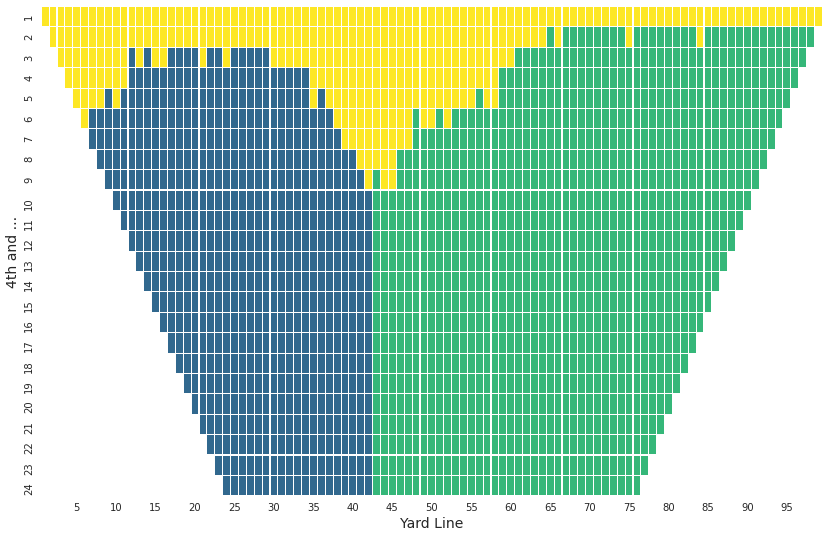

In [141]:
plt.figure(figsize=(14, 9))
# sns.heatmap(choiceArrayNP, vmin=0, vmax=3, xticklabels=5, yticklabels=2, cmap="YlGnBu", cbar=False)
with sns.axes_style("white"):
    ax = sns.heatmap(choiceArrayNP, mask=choice_mask.mask, vmin=0, vmax=3, xticklabels=5, yticklabels=1, 
                     cmap="viridis", cbar=False, linewidths=.1)
    ax.set(xlim=(1, 100), ylim=(25, 1))
#     ax.set_xticklabels([])
plt.ylabel("4th and ...", fontsize=14)
plt.xlabel("Yard Line", fontsize=14)
plt.show()



In [53]:
choiceArray

{1: {1: 'Go For It'},
 2: {1: 'Go For It', 2: 'Go For It'},
 3: {1: 'Go For It', 2: 'Go For It', 3: 'Go For It'},
 4: {1: 'Go For It', 2: 'Go For It', 3: 'Go For It', 4: 'Go For It'},
 5: {1: 'Go For It',
  2: 'Go For It',
  3: 'Go For It',
  4: 'Go For It',
  5: 'Go For It'},
 6: {1: 'Go For It',
  2: 'Go For It',
  3: 'Go For It',
  4: 'Go For It',
  5: 'Go For It',
  6: 'Go For It'},
 7: {1: 'Go For It',
  2: 'Go For It',
  3: 'Go For It',
  4: 'Go For It',
  5: 'Go For It',
  6: 'FG',
  7: 'FG'},
 8: {1: 'Go For It',
  2: 'Go For It',
  3: 'Go For It',
  4: 'Go For It',
  5: 'Go For It',
  6: 'FG',
  7: 'FG',
  8: 'FG'},
 9: {1: 'Go For It',
  2: 'Go For It',
  3: 'Go For It',
  4: 'Go For It',
  5: 'FG',
  6: 'FG',
  7: 'FG',
  8: 'FG',
  9: 'FG'},
 10: {1: 'Go For It',
  2: 'Go For It',
  3: 'Go For It',
  4: 'Go For It',
  5: 'Go For It',
  6: 'FG',
  7: 'FG',
  8: 'FG',
  9: 'FG',
  10: 'FG'},
 11: {1: 'Go For It',
  2: 'Go For It',
  3: 'Go For It',
  4: 'Go For It',
  5: 'FG'

In [174]:
dict = {"a": 1, "b": 2, "c": 3, "d": 4}

data = list(expectedPointsArray.items())
an_array = np.array(data)

pd.DataFrame(an_array)

,0,1
0,2,{1: 3.6201038153040948}
1,3,"{1: 3.4363607706234576, 2: 3.04112494295644}"
2,4,"{1: 3.49589065893681, 2: 2.9759857617066587, 3..."
3,5,"{1: 3.2978932211472585, 2: 2.9486103467199247,..."
4,6,"{1: 3.225992190623181, 2: 2.7506423122223596, ..."
...,...,...
93,95,"{1: -1.6816596609499035, 2: -2.057542768273717..."
94,96,"{1: -1.7746392691934514, 2: -2.139521956642579..."
95,97,"{1: -1.9111904720305533, 2: -2.010410958904109..."
96,98,"{1: -1.8029199229098136, 2: -2.095766129032258..."


Text(0.5, 0.98, 'Kicking success rate by field position')

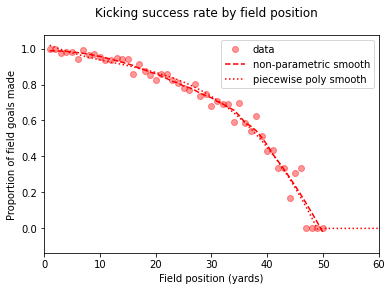

In [19]:
def non_parametric_smooth_with_nan(y,smooth_type='savgol',window=21):
    if smooth_type=='savgol':
        y[~np.isnan(y)] = signal.savgol_filter(y[~np.isnan(y)],window,2)
    return y

def poly_smooth_with_nan(x,y,deg):
    nanvals = np.isnan(y)
    pfit,cov = np.polyfit(x[~nanvals],y[~nanvals],deg, cov=True)
    yp = np.poly1d(pfit)(x)
    return yp,pfit,cov


# find field goal attempts
field_goal_attempts = nfl_pbp[nfl_pbp['field_goal_attempt']==1]
# initialize arrays
field_goal_success_rate = np.zeros(99)
field_goal_number_attempts = np.zeros(99)
field_position = np.arange(1,100) # i.e. from 1-99 yards
for i in field_position: # i.e. from 1-99 yards
    relevant_rows = field_goal_attempts.yardline_100==i
    field_goal_number_attempts[i-1] = np.sum(relevant_rows)
    if field_goal_number_attempts[i-1]>0:
        field_goal_success_rate[i-1] = np.sum( field_goal_attempts[relevant_rows].posteam_score_post > field_goal_attempts[relevant_rows].posteam_score) / np.sum(relevant_rows)
    else:
        field_goal_success_rate[i-1] = np.nan # no data at this distance
    

# non-parmetric filter
field_goal_success_rate_smooth_noparam = non_parametric_smooth_with_nan(field_goal_success_rate.copy(),window=21)

# make piecewise polynomial fit
field_goal_success_rate_smooth_poly = np.zeros(99)
cut_distance = 49 # anything greater than this is set to zero
field_goal_success_rate_smooth_poly[field_position<=cut_distance] = poly_smooth_with_nan(field_position[field_position<=cut_distance],field_goal_success_rate[field_position<=cut_distance],deg=3)[0]


fig,ax = plt.subplots()
ax.plot(field_position,field_goal_success_rate,'ro',alpha=0.4,label='data')
ax.plot(field_position,field_goal_success_rate_smooth_noparam,'r--',label='non-parametric smooth')
ax.plot(field_position,field_goal_success_rate_smooth_poly,'r:',label='piecewise poly smooth')
ax.set_xlabel('Field position (yards)')
ax.legend()
ax.set_ylabel('Proportion of field goals made')
ax.set_xlim(0,60)
fig.suptitle('Kicking success rate by field position')

    